In [1]:
import scanpy as sc
import pycisTopic
from pycisTopic.cistopic_class import *
import pickle
import os
import anndata
import mudata
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyvis.network import Network


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
def visualize_regulatory_network(metadata_df, importance_col='importance', weight_col='importance_TF2G',
                               top_n=100, output_html='figures/network.html',title='SCENIC+ Regulatory Network',df_deg=None):
    """
    Visualize SCENIC+ regulatory network with TF-gene relationships
    
    Parameters:
        metadata_df: DataFrame with columns ['TF', 'gene', importance_col, 'region']
        importance_col: Column name for TF-gene importance scores
        top_n: Number of top interactions to visualize
        output_html: Output file name for interactive visualization
    """
    # Prepare data
    # Sort by the absolute importance and select top_n interactions

    df = metadata_df.sort_values(importance_col, ascending=False).head(top_n)
    #df = metadata_df.sort_values(importance_col, ascending=False)
    
    # Create network graph
    G = nx.DiGraph()
    
    # Add nodes and edges with importance as weight
    for _, row in df.iterrows():
        G.add_edge(row['TF'], row['Gene'], 
                  weight=row[weight_col],
                  title=f"Importance: {row[weight_col]:.2f}")
        
    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees else 1

    
    # Node colors (TFs in red, genes in blue)
    # Node colores, where TFs are orange and genes are magenta, not in df_deg are gray

    node_colors = {}
    for node in G.nodes():
        if node in df['TF'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = 'orange'
            else:
                node_colors[node] = 'yellow'
        elif node in df['Gene'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = 'magenta'
            else:
                node_colors[node] = 'pink'
        else:
            node_colors[node] = 'lightgray'  # For nodes not in df_deg
    # node_colors = {
    #     node: 'orange' if node in df['TF'].unique() else 'magenta'
    #     for node in G.nodes()
    # }
    
    # Static visualization
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Draw nodes

    node_sizes = [degrees[n] * 800 / max_degree for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes()],
                          node_size=node_sizes, alpha=0.8)

    # Draw edges with width proportional to importance
    edge_widths = [d['weight']*2 for u, v, d in G.edges(data=True)]
    # nx.draw_networkx_edges(G, pos, width=edge_widths, 
    #                       edge_color='gray', alpha=0.6, 
    #                       arrowstyle='-|>', arrowsize=15)
    for u, v, d in G.edges(data=True):
        arrowstyle = '-|>' if d['weight'] >= 0 else '-['
        color = 'gray' if d['weight'] >= 0 else 'pink'
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=abs(d['weight'])*2,
            edge_color=color,
            alpha=0.6,
            arrowstyle=arrowstyle,
            arrowsize=15
        )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_html+".png", dpi=300)
    plt.show()
    
    # Interactive visualization
    net = Network(height='800px', width='100%', directed=True)
    net.from_nx(G)
    
    # Set node colors and sizes
    # for node in net.nodes:
    #     node['color'] = 'red' if node['label'] in df['TF'].unique() else 'blue'
    #     node['size'] = 20 if node['label'] in df['TF'].unique() else 15
    

    # for edge in net.edges:
    #     weight = G.edges[edge['from'], edge['to']]['weight']
    #     if weight >= 0:
    #         edge['color'] = {'color': 'green', 'highlight': 'lime'}
    #         edge['arrows'] = 'to'
    #     else:
    #         edge['color'] = {'color': 'lightblue', 'highlight': 'lightblue'}  # Changed to lightblue
    #         edge['arrows'] = 'to'
    #         edge['dashes'] = True

    # Save interactive version
    net.show_buttons(filter_=['physics'])
    net.save_graph(output_html)
    print(f"Interactive visualization saved to {output_html}")

# Example usage with test data
# if __name__ == "__main__":
    # Create test data matching SCENIC+ format
# test_data = {
#     'TF': ['TF1', 'TF1', 'TF2', 'TF2', 'TF3', 'TF3'],
#     'gene': ['GeneA', 'GeneB', 'GeneC', 'GeneD', 'GeneE', 'GeneF'],
#     'importance': [0.9, 0.8, 0.7, 0.6, 0.5, 0.4],
#     'region': ['chr1:100-200', 'chr1:300-400', 'chr2:100-200', 
#                 'chr3:100-200', 'chr4:100-200', 'chr5:100-200']
# }


In [ ]:
cac_gene_dict = {'α1 subunit': ['Cacna1a',
  'Cacna1b',
  'Cacna1c',
  'Cacna1d',
  'Cacna1e',
  'Cacna1g',
  'Cacna1h',
  'Cacna1i'],
 'α2δ subunit': ['Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4'],
 'β subunit': ['Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4'],
 'γ subunit': ['Cacng2', 'Cacng3', 'Cacng4', 'Cacng5', 'Cacng7', 'Cacng8'],
 'None': ['Cacfd1', 'Cachd1']}

ca_genes = ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d', 'Cacna1e', 'Cacna1g', 
            'Cacna1h', 'Cacna1i', 'Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4', 
            'Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4', 'Cacng2', 'Cacng3', 'Cacng4', 
            'Cacng5', 'Cacng7', 'Cacng8', 'Cacfd1', 'Cachd1']


ligand = ['Slc18a2', 'Slc18a1', 'Ddc', 'Th', 'Slc17a7', 'Slc17a8', 'Gls',
       'Slc17a6', 'Slc18a3', 'Chat', 'Slc32a1', 'Dbh', 'Tph2', 'Tph1', 'Gad2',
       'Gad1', 'Pnmt', 'Shmt2', 'Shmt1', 'Hmox2', 'Nos3', 'Hmox1', 'Cort',
       'Nos2', 'Nos1', 'Sst', 'Adcyap1', 'Rln1', 'Nrxn3', 'Npy', 'Nrxn2',
       'Nrxn1', 'Pdyn', 'Vip', 'Trh', 'Crh', 'Nts', 'Penk', 'Tac1', 'Pthlh',
       'Pnoc', 'Tac2', 'Gjc1', 'Gjc2', 'Gjc3', 'Gjd2', 'Gjd3', 'Gjd4', 'Gje1',
       'Gjb6', 'Gjb5', 'Gjb4', 'Gjb3', 'Gjb2', 'Gjb1', 'Gja8', 'Gja6', 'Cck',
       'Grp', 'Gja5', 'Gja4', 'Gja1', 'Gja3', 'Gja10', 'Nmb']

receptor = ['Oprl1', 'Gabra6', 'Grik3', 'Gabrb3', 'Grik5', 'Adrb1', 'Oprd1', 'Gabra4', 
            'Grm5', 'Drd4', 'Npy1r', 'Grin2c', 'Slc6a4', 'Gjc3', 'Chrna7', 'Rxfp1', 'Adra1b', 
            'Gjb1', 'Oprm1', 'Nlgn2', 'Drd5', 'Chrm5', 'Gabra1', 'Htr5a', 'Pth1r', 'Oprk1', 'Tacr3', 
            'Chrna1', 'Grm7', 'Grik2', 'Chrna6', 'Adra1a', 'Gucy1b2', 'Slc6a3', 'Adra2b', 'Gabbr1', 'Chrna4', 
            'Gjb4', 'Htr1b', 'Gja1', 'Npy2r', 'Gucy1a1', 'Gabrb1', 'Grin1', 'Adra2a', 'Tacr1', 'Adrb2', 'Sstr2', 
            'Grin3a', 'Glra2', 'Slc6a2', 'Drd3', 'Htr1d', 'Adra2c', 'Htr2c', 'Grin2d', 'Chrnb1', 'Chrnb2', 'Gja4', 'Htr7', 
            'Htr2b', 'Gabra3', 'Ache', 'Grik4', 'Htr6', 'Grm1', 'Sstr4', 'Gjb2', 'Grm6', 'Adcyap1r1', 'Adra1d', 'Gria2', 
            'Chrna2', 'Grm3', 'Grik1', 'Chrm3', 'Rxfp3', 'Chrna10', 'Chrng', 'Gjb3', 'Crhr2', 'Grin3b', 'Gria3', 'Vipr1', 'Gria1', 
            'Grin2b', 'Htr4', 'Slc6a9', 'Npy5r', 'Gja3', 'Htr1f', 'Chrnb3', 'Gjd4', 'Nlgn3', 'Gjd2', 'Grm4', 'Sstr1', 'Grin2a', 'Gabrg2', 
            'Adrb3', 'Grm2', 'Gja8', 'Glra3', 'Gje1', 'Comt', 'Sstr3', 'Gjb5', 'Gabra2', 'Rxfp2', 'Chrne', 'Gabrg3', 'Vipr2', 'Cckbr', 'Htr1a', 
            'Chrm2', 'Gucy1a2', 'Htr2a', 'Ntsr2', 'Ntsr1', 'Htr3b', 'Gabrb2', 'Gja6', 'Drd2', 'Glra1', 'Grm8', 'Chrnd', 'Nmbr', 'Glrb', 'Trhr', 
            'Gria4', 'Gja5', 'Chrna9', 'Gucy1b1', 'Nlgn1', 'Drd1', 'Gjc1', 'Glra4', 'Crhr1', 'Chrna5', 'Gjc2', 'Gjd3', 'Trhr2', 'Gabra5', 'Htr1e', 
            'Htr3a', 'Slc6a5', 'Gja10', 'Chrna3', 'Chrm4', 'Gjb6', 'Chrnb4', 'Chrm1', 'Gabrg1', 'Gabbr2', 'Grpr']


respriotory = ['mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Atp6', 'mt-Nd4', 'mt-Nd1', 'Cox6c',
       'Cox8a', 'Cox4i1', 'Sdha', 'Ndufa4', 'Ndufs4', 'Cox7c', 'Ndufc2',
       'Ndufaf7', 'Ndufa13', 'Atp5f1', 'Ndufaf4', 'Cox7a2', 'Cox7b', 'Cox6a1',
       'Ndufs1', 'Ndufv2', 'Ndufb5', 'Uqcrh', 'Uqcrc2', 'Ndufaf2', 'Ndufb9',
       'Cox5a', 'Ndufa10', 'Ndufb1-ps', 'mt-Nd2', 'Ndufa6', 'Cox5b', 'Ndufb11',
       'Ndufb3', 'Cox6b1', 'Ndufs3', 'Uqcrq', 'Cyc1', 'Ndufb4', 'Coq2', 'Sdhb',
       'Ndufa7', 'Ndufs7', 'Ndufa12', 'Ndufb8', 'Ndufa11', 'Ndufb10', 'Ndufa3',
       'Coa3', 'Uqcrb', 'Ndufab1', 'Ndufa5', 'Uqcrc1', 'Sod2', 'Uqcr11',
       'Uqcr10', 'Sdhc', 'Ndufb2', 'Ndufa2', 'Ndufv3', 'Ndufs2', 'Ndufa1',
       'Ndufb7', 'Cycs', 'Ndufv1', 'Ndufa8', 'Coq3', 'Ndufc1', 'Ndufa9',
       'Coq5', 'Ndufb6', 'Coq8b', 'Ndufs8', 'Ndufaf5', 'Coq9', 'Ndufaf6',
       'Ndufs6', 'Tfam', 'mt-Nd3', 'mt-Nd5', 'Coq4', 'Sdhd', 'Coq7', 'Ndufaf3',
       'mt-Nd4l', 'Coa5', 'Coa7', 'Cox6a2', 'Cox4i2']

In [40]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)
df_deg = df_deg[df_deg['gender'] == "M"]
df_deg = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]
df_deg['condition'] = 'DOWN'
df_deg.loc[df_deg.de_coef>0,'condition'] = 'UP'

/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


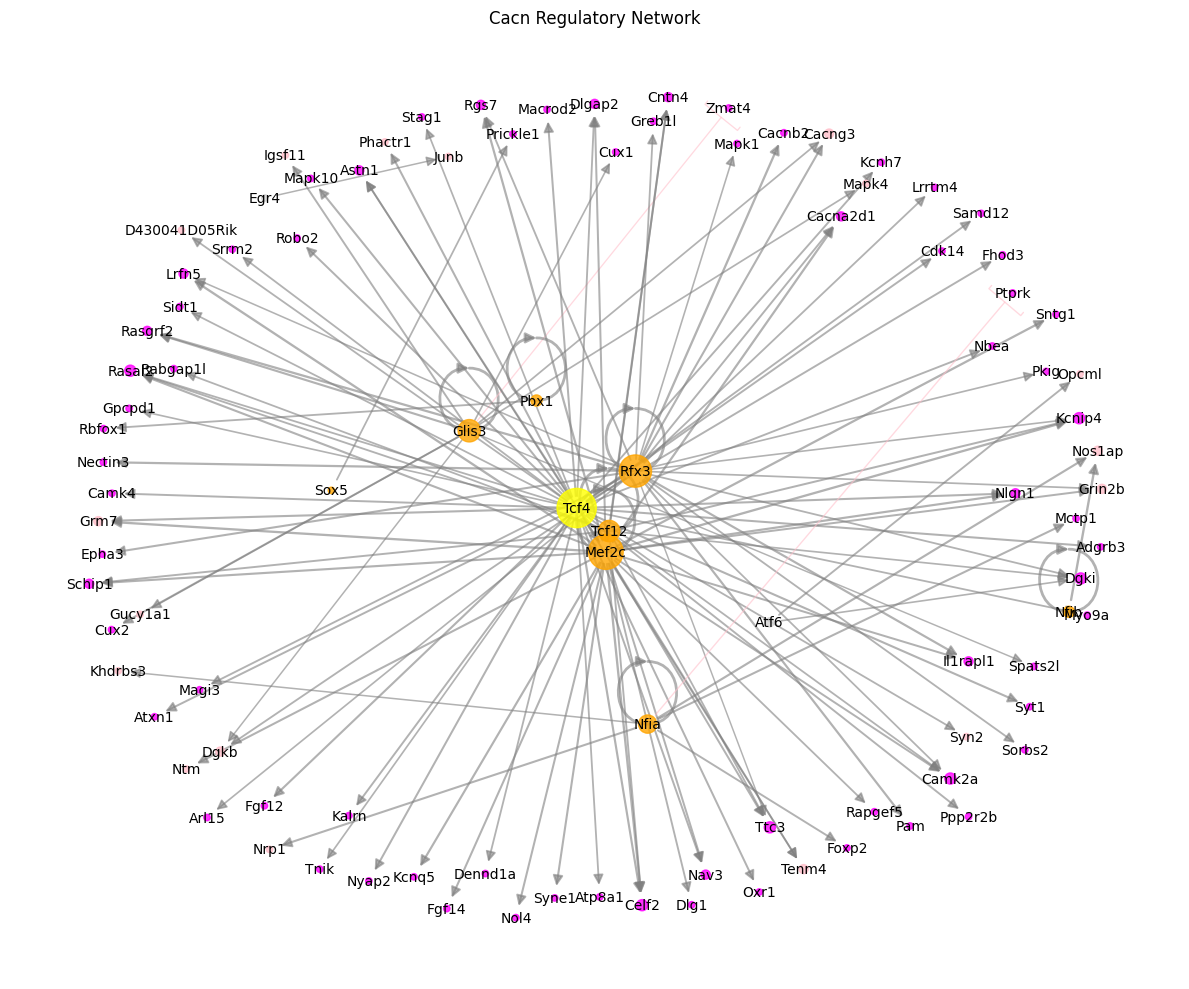

Interactive visualization saved to figures/PFC_PFC_Glut_deg_network.html


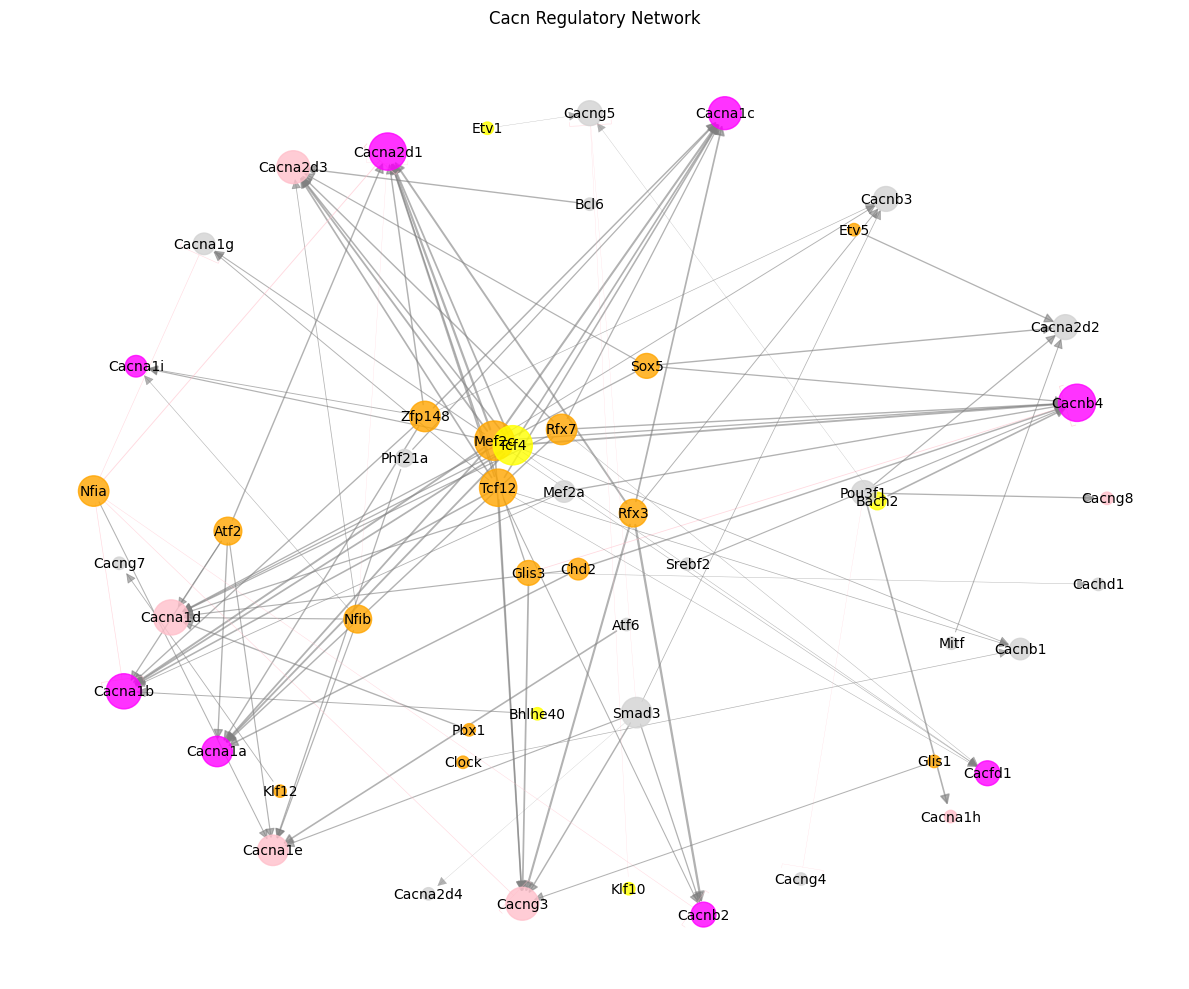

Interactive visualization saved to figures/PFC_PFC_Glut_ca_network.html


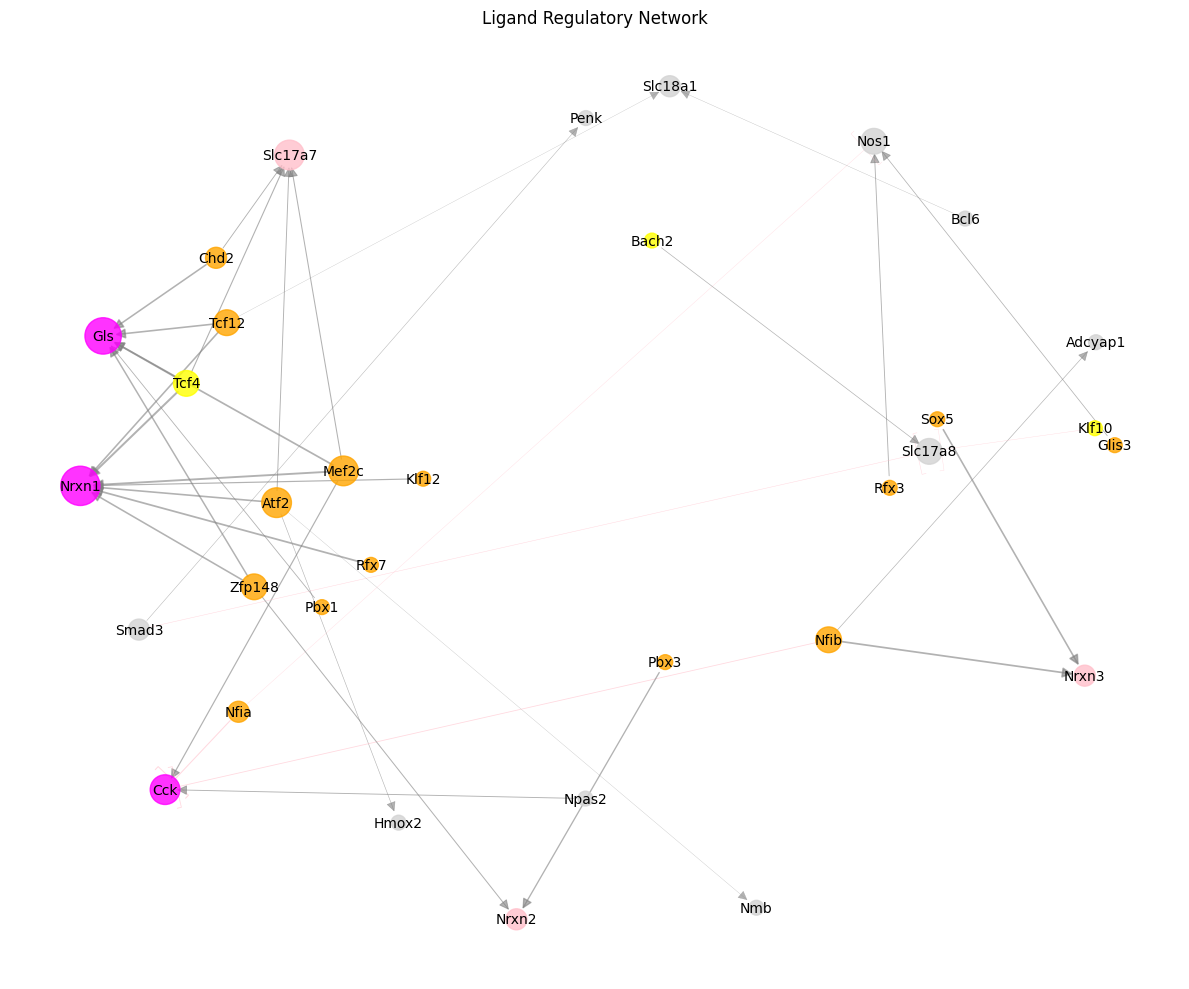

Interactive visualization saved to figures/PFC_PFC_Glut_ligand_network.html


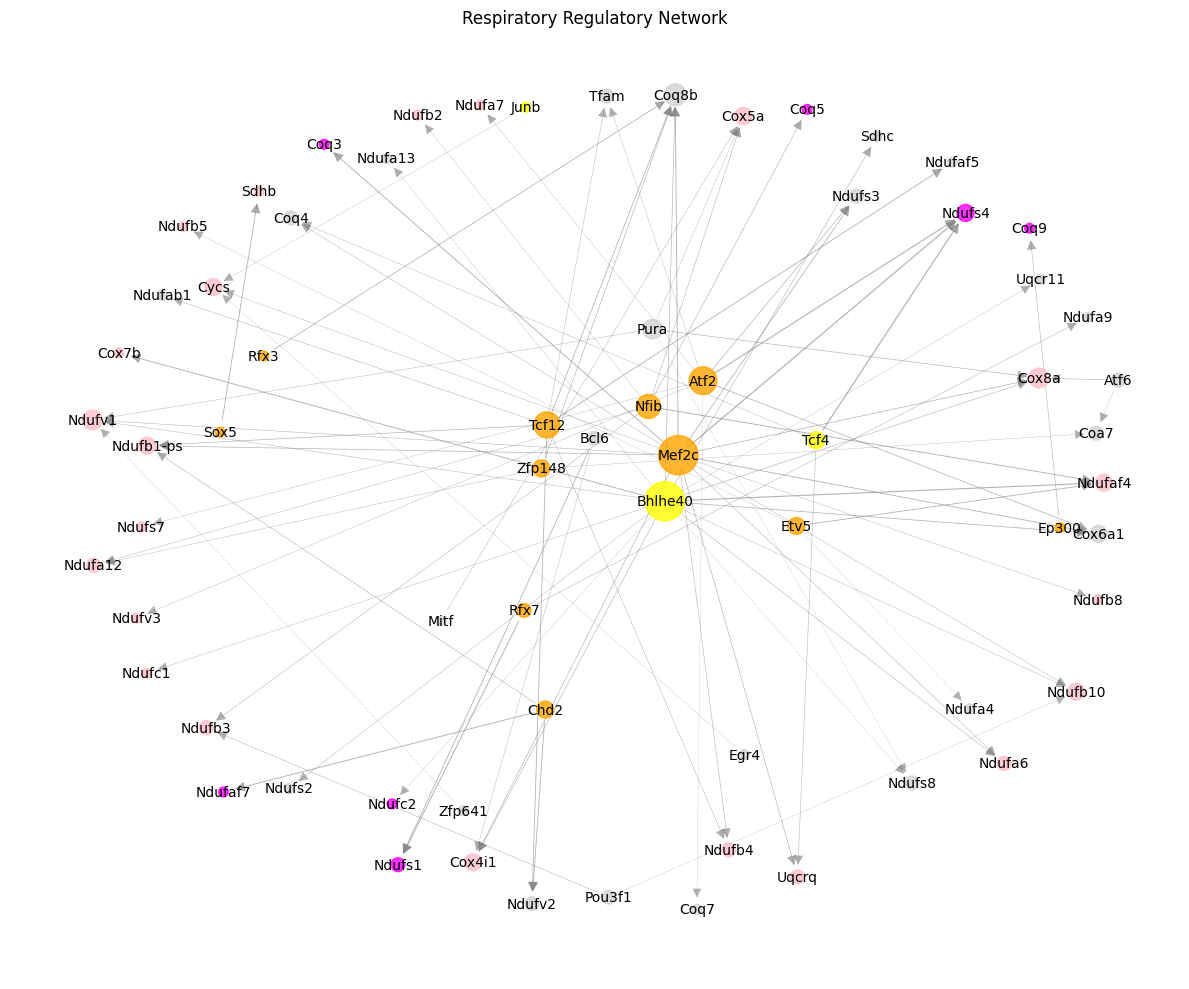

Interactive visualization saved to figures/PFC_PFC_Glut_respiratory_network.html


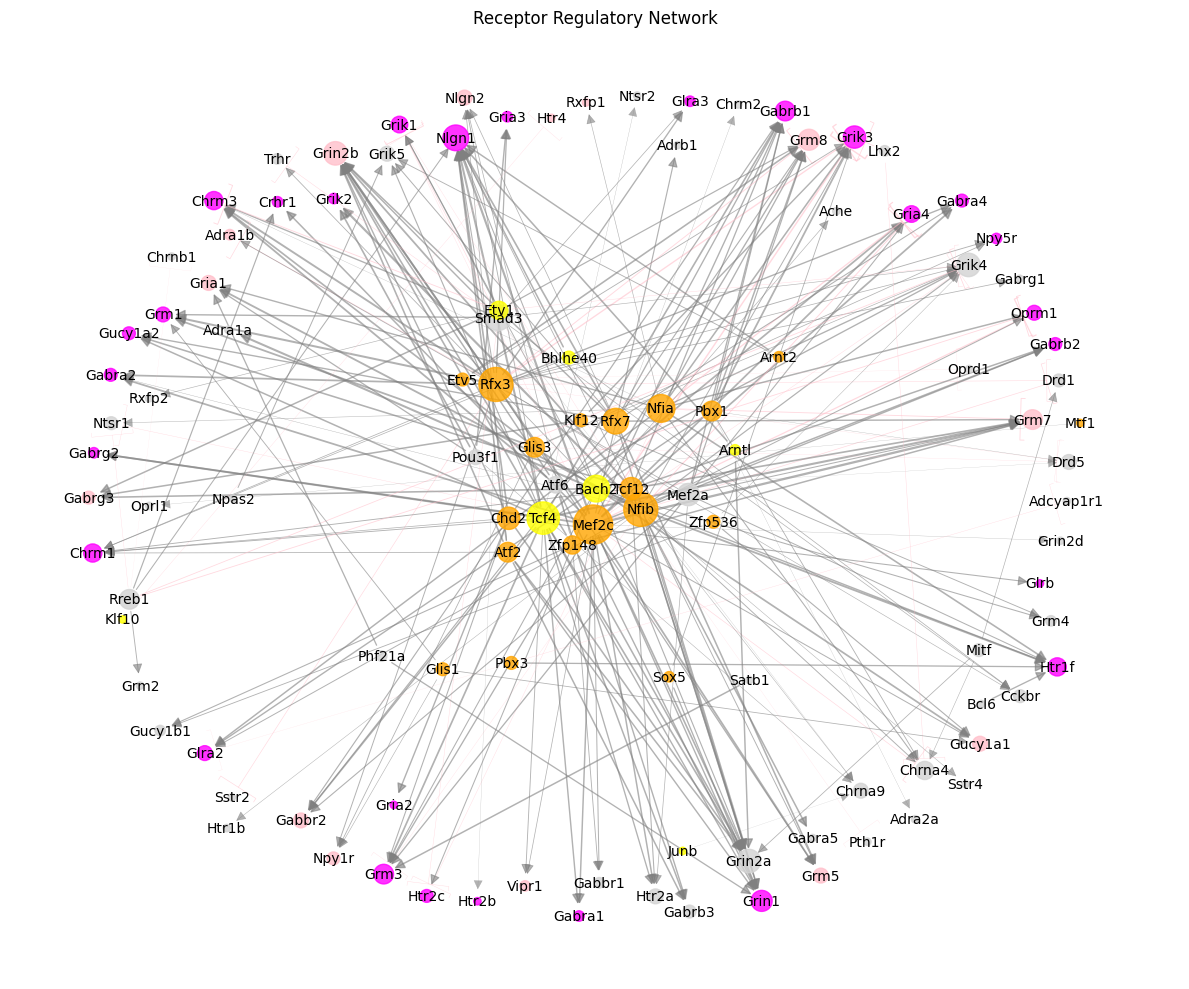

Interactive visualization saved to figures/PFC_PFC_Glut_receptor_network.html


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


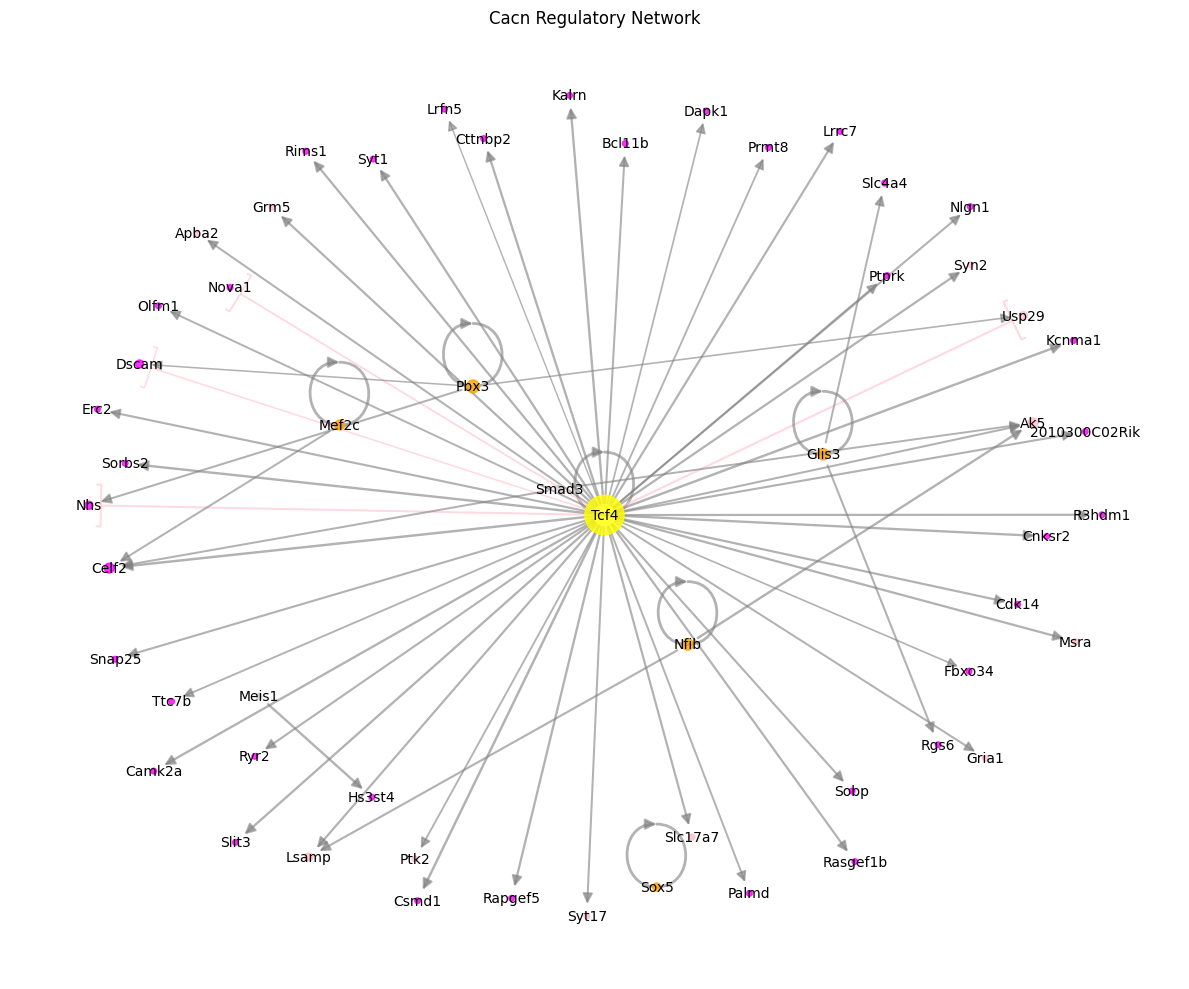

Interactive visualization saved to figures/AMY_AMY_Glut_deg_network.html


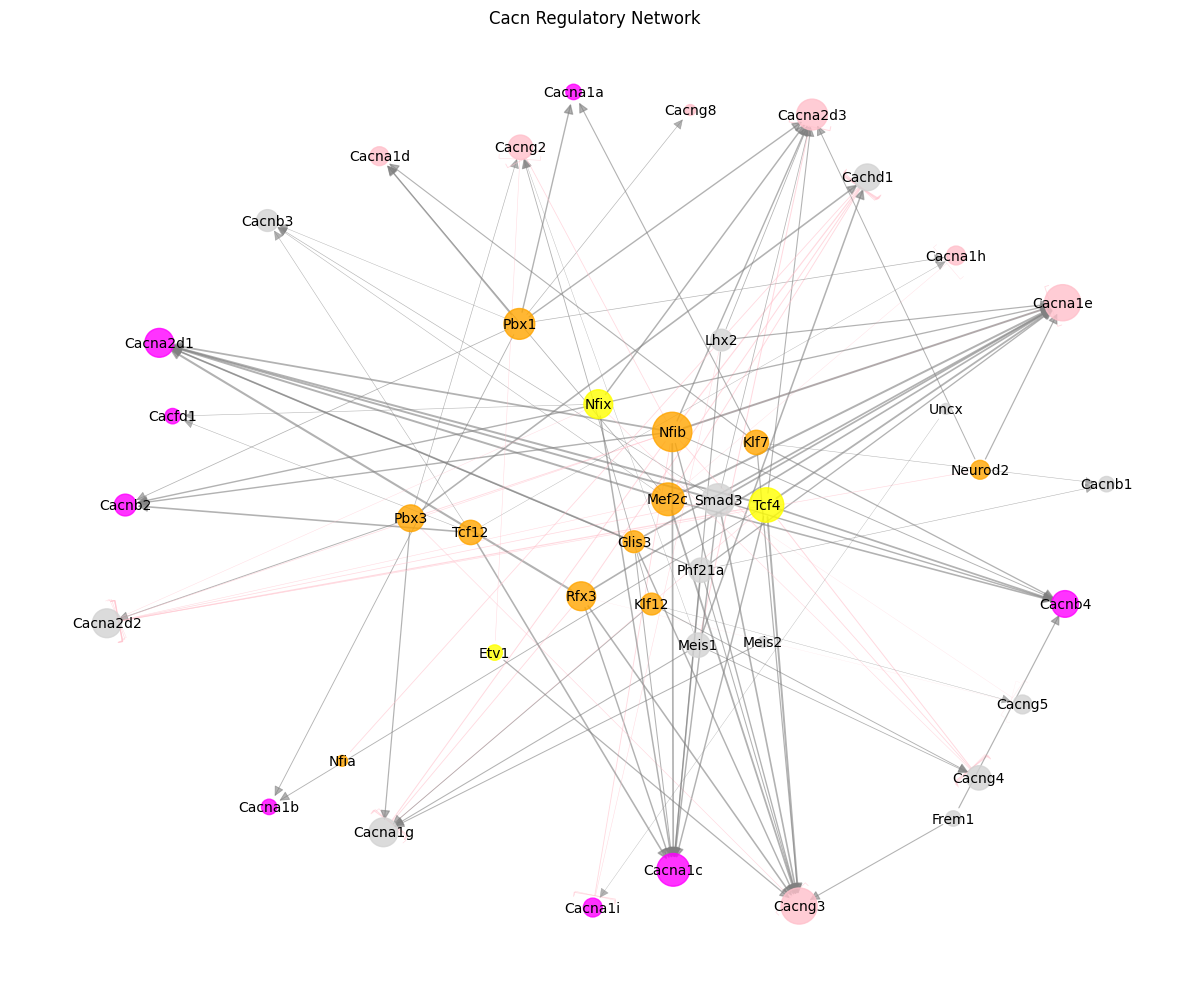

Interactive visualization saved to figures/AMY_AMY_Glut_ca_network.html


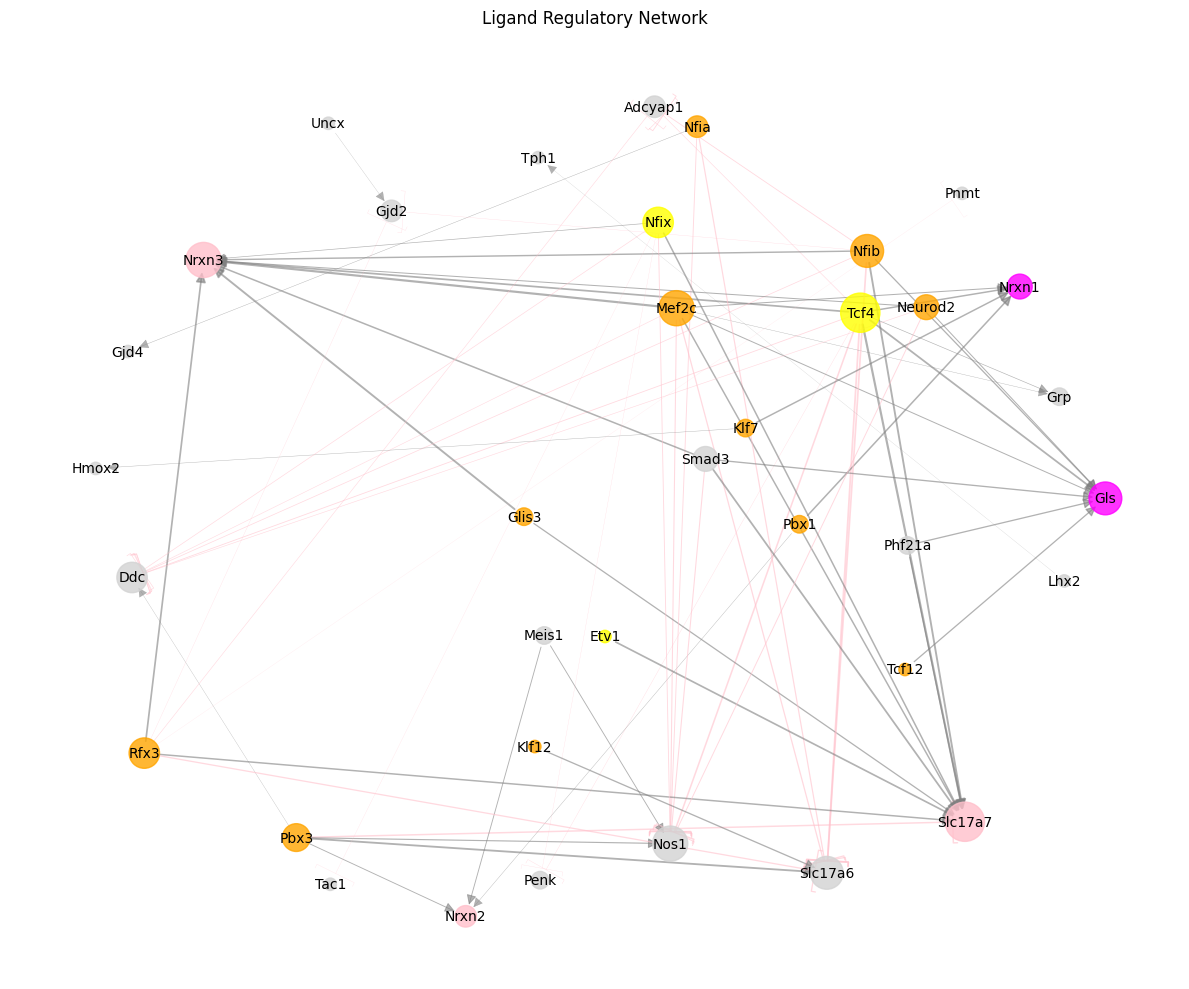

Interactive visualization saved to figures/AMY_AMY_Glut_ligand_network.html


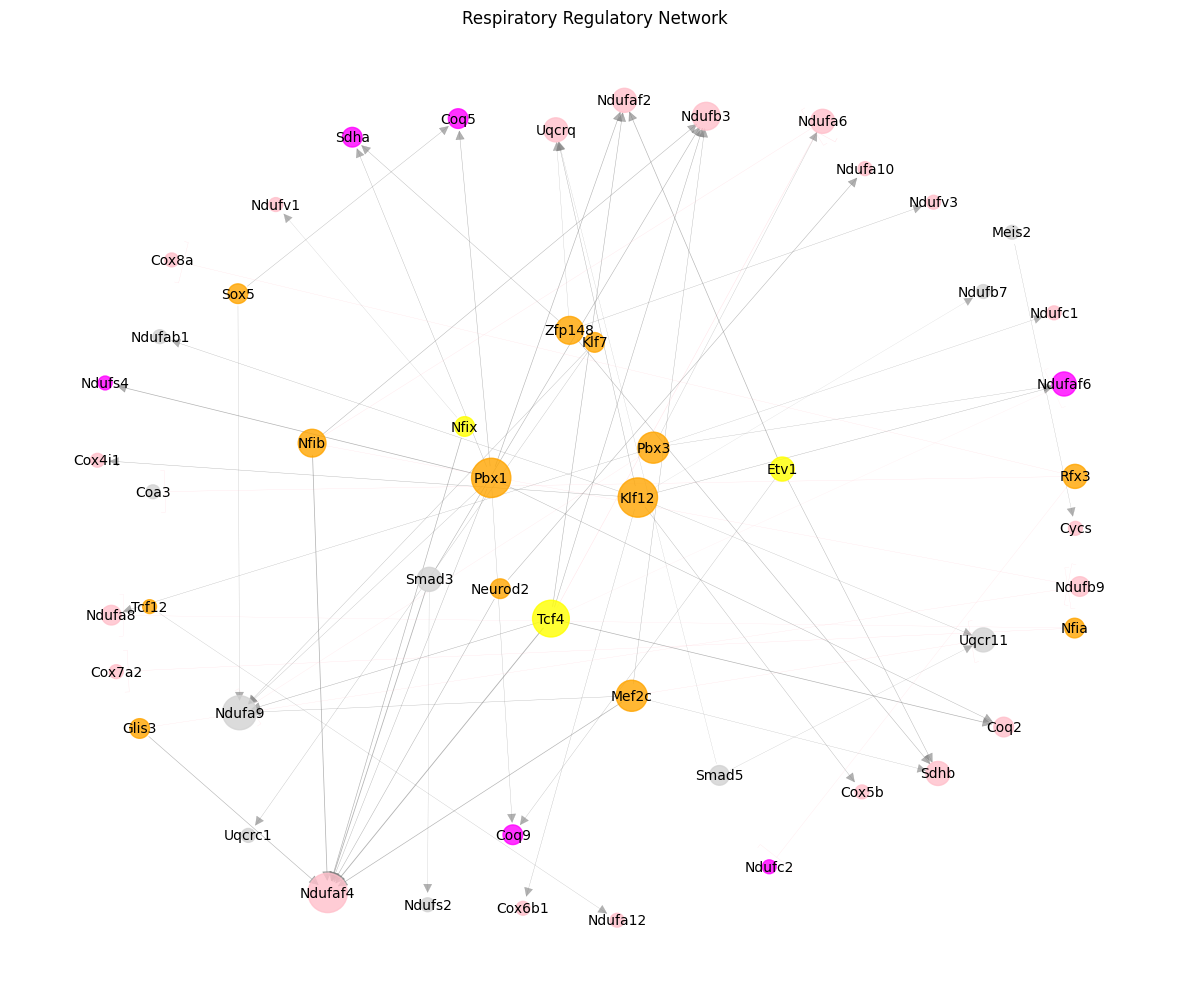

Interactive visualization saved to figures/AMY_AMY_Glut_respiratory_network.html


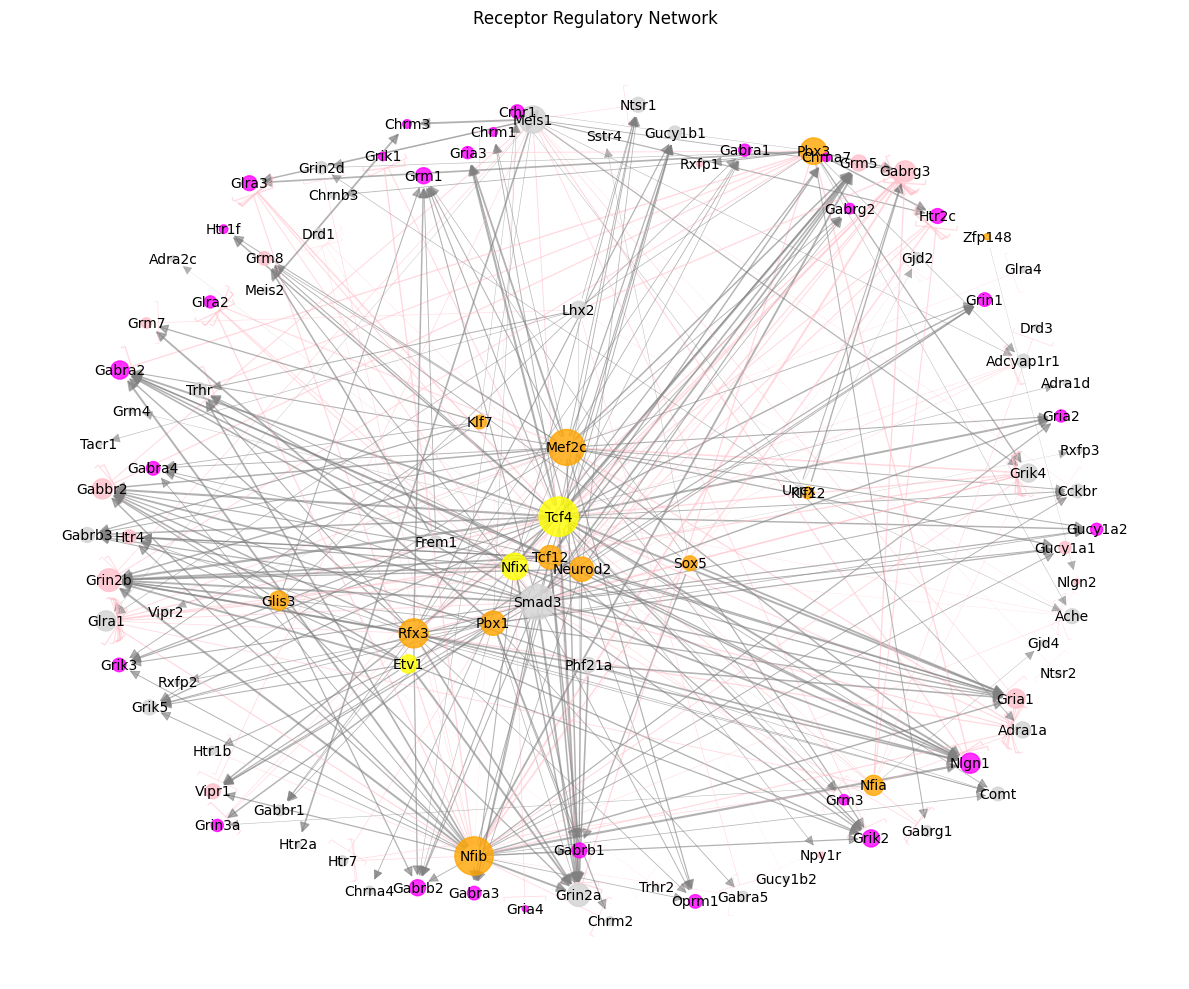

Interactive visualization saved to figures/AMY_AMY_Glut_receptor_network.html


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


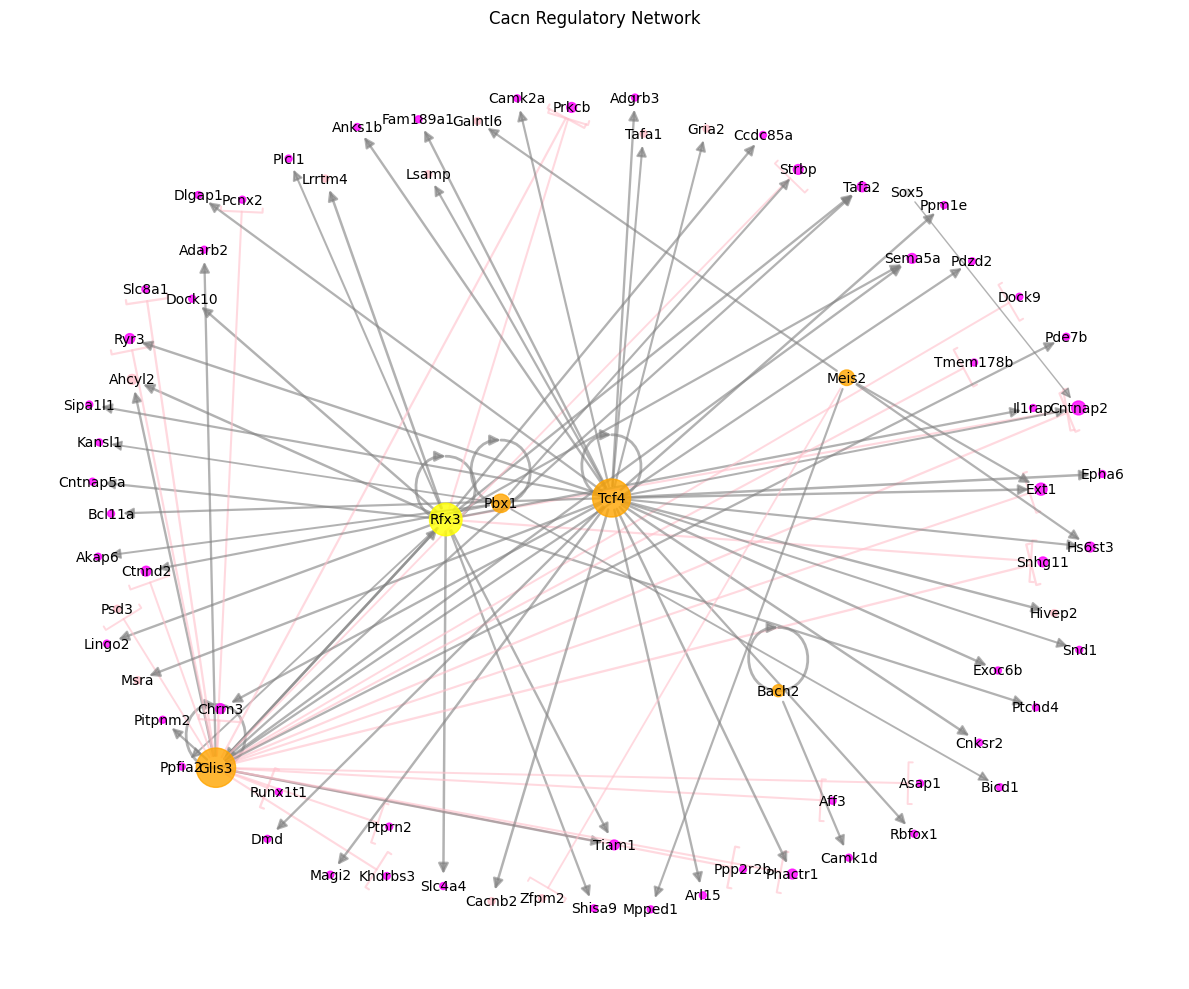

Interactive visualization saved to figures/HIP_HIP_Glut_deg_network.html


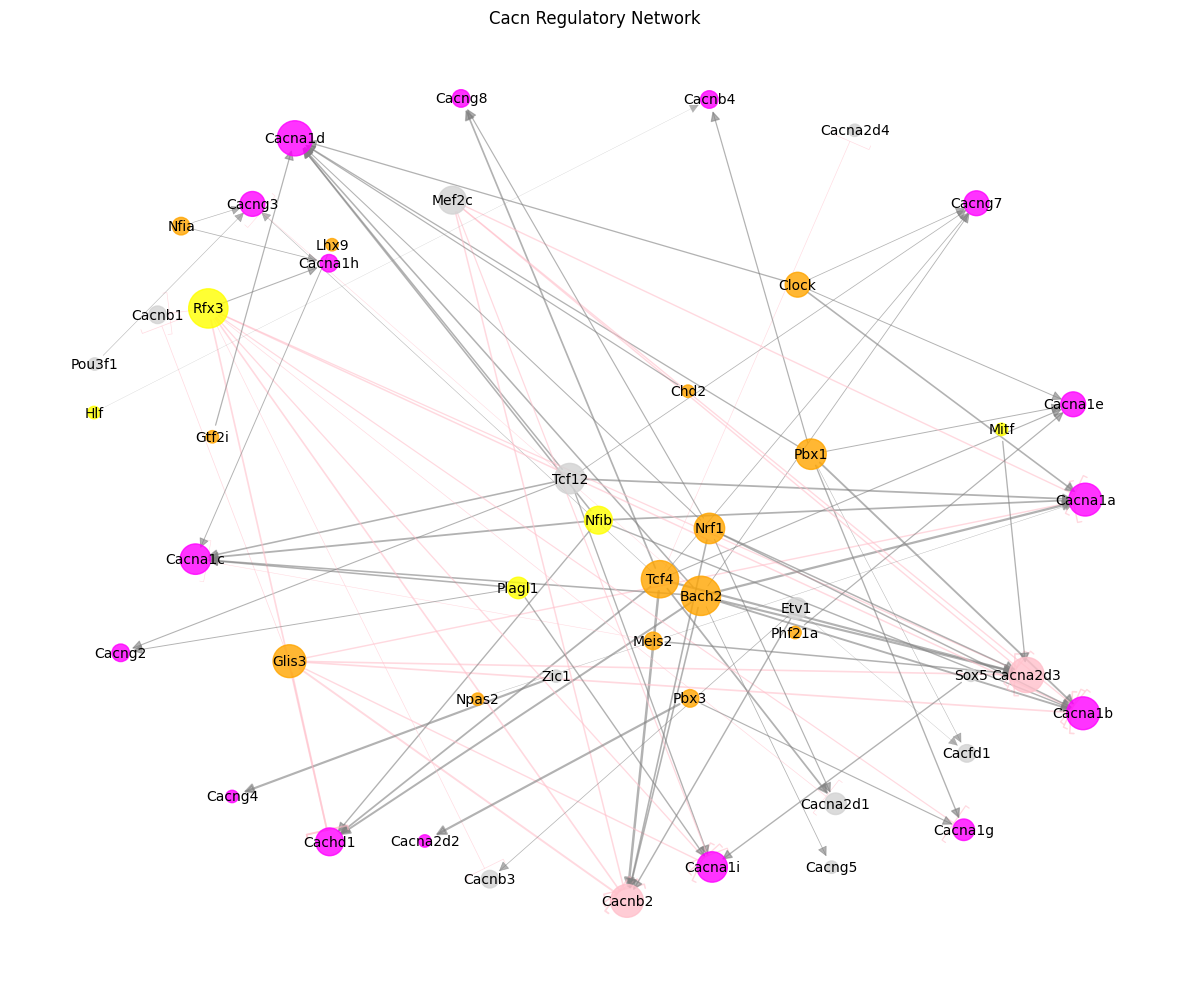

Interactive visualization saved to figures/HIP_HIP_Glut_ca_network.html


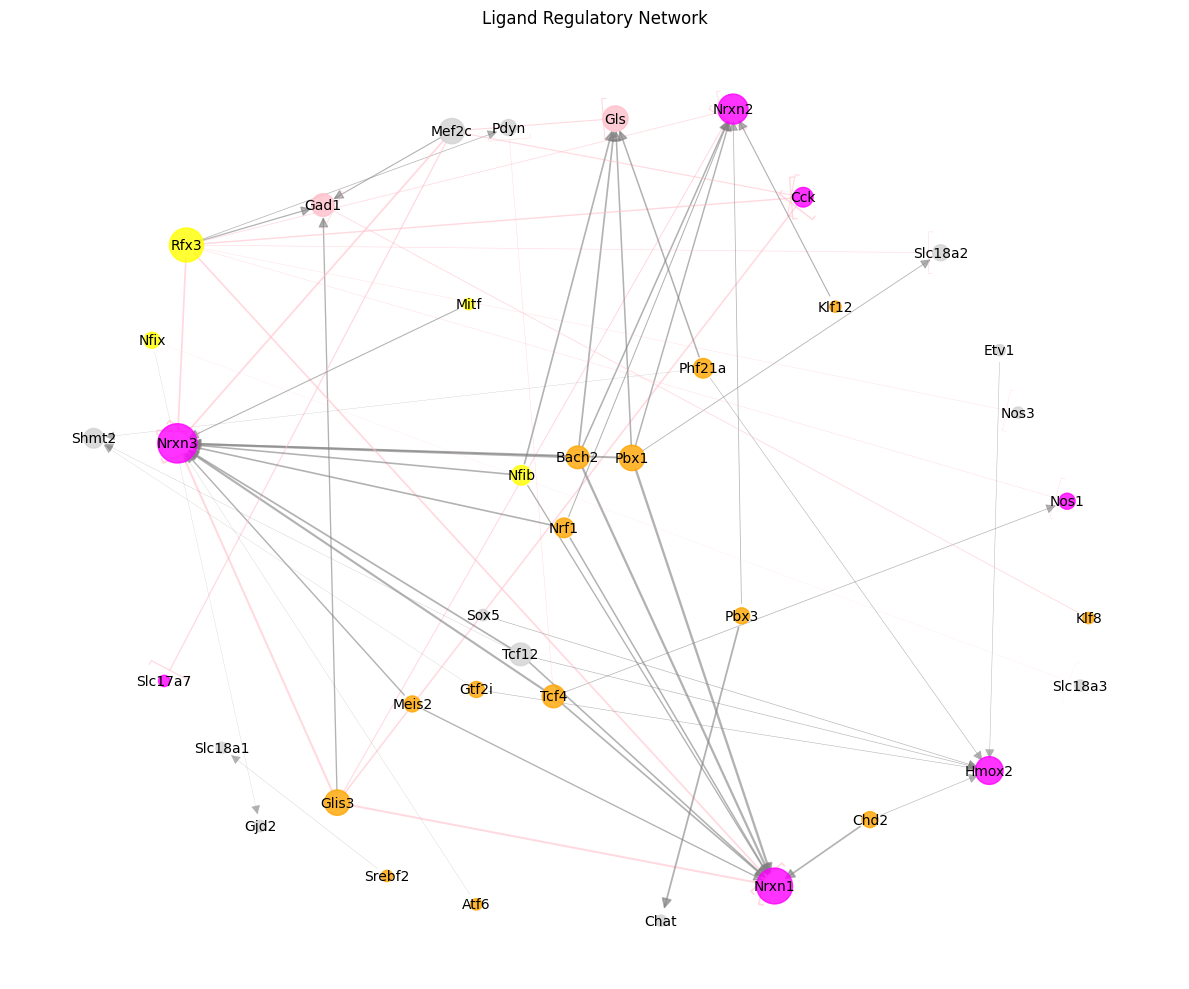

Interactive visualization saved to figures/HIP_HIP_Glut_ligand_network.html


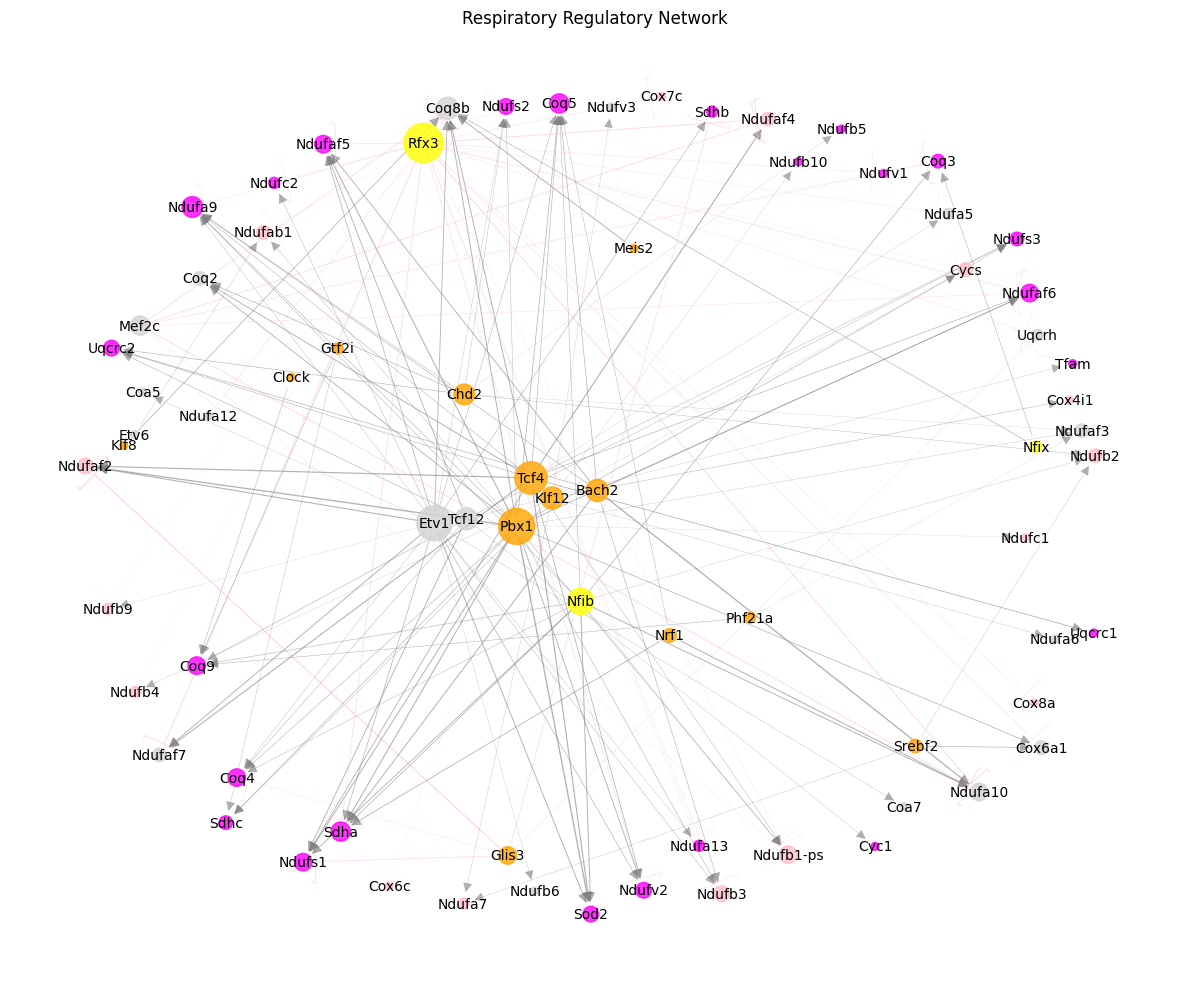

Interactive visualization saved to figures/HIP_HIP_Glut_respiratory_network.html


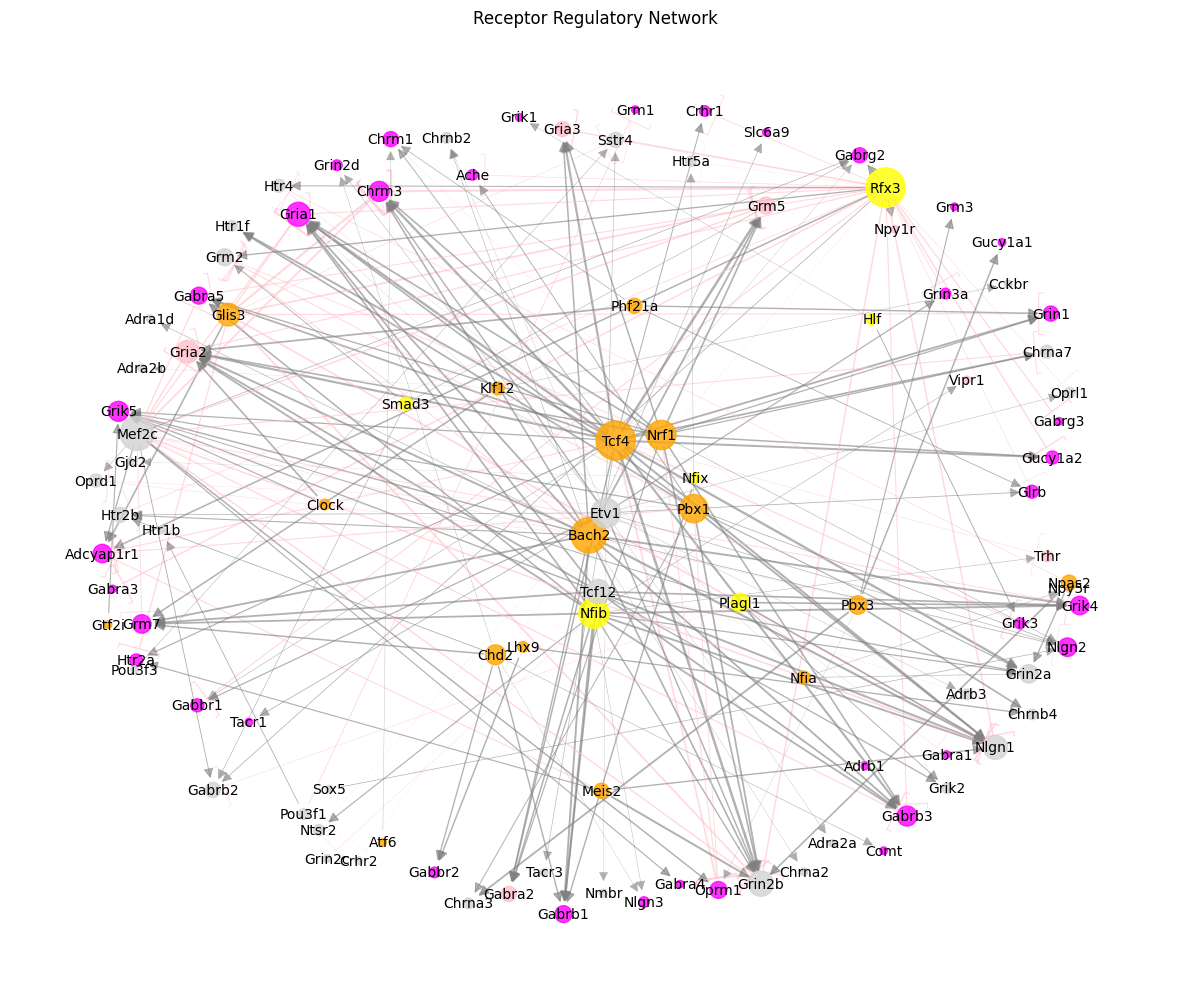

Interactive visualization saved to figures/HIP_HIP_Glut_receptor_network.html


In [41]:
cellltypes = ['PFC_PFC_Glut', 'AMY_AMY_Glut', 'HIP_HIP_Glut']
for cellltype in cellltypes:
    df_deg_select = df_deg[df_deg['ctname'] == ctname]
    ctname = cellltype[4:]
    oudir = f'/data1st2/junyi/output/atac0416/scenic/{cellltype}/Snakemake'
    scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')

    direct_er = scplus_mdata.uns["direct_e_regulon_metadata"]
    direct_er.sort_values(['importance_TF2G'], ascending=False, inplace=True)
    deg = direct_er[direct_er.Gene.isin(df_deg_select.gene)].copy()
    visualize_regulatory_network(deg,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=400,title='Cacn Regulatory Network',output_html=f'figures/{cellltype}_deg_network.html')

    TF_gcount = pd.DataFrame(direct_er.groupby(['TF']).nunique()['Gene'].sort_values(ascending=False))
    TF_degcount = pd.DataFrame(deg.groupby(['TF']).nunique()['Gene'])
    df_importance = TF_degcount.merge(TF_gcount, left_index=True, right_index=True, how='right', suffixes=('_deg', '_all')).fillna(0)
    df_importance['degratio'] = df_importance['Gene_deg'] / df_importance['Gene_all']
    df_importance.sort_values('degratio', ascending=False, inplace=True)
    df_importance['ctname'] = ctname
    df_importance.to_csv(f'figures/{cellltype}_TF_deg_ratio.csv')
    ca_df = direct_er[direct_er.Gene.isin(ca_genes)].copy()
    visualize_regulatory_network(ca_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(ca_df),title='Cacn Regulatory Network',output_html=f'figures/{cellltype}_ca_network.html')

    ligand_df = direct_er[direct_er.Gene.isin(ligand)].copy()

    visualize_regulatory_network(ligand_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(ligand_df),title='Ligand Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_ligand_network.html')

    atp_df = direct_er[direct_er.Gene.isin(respriotory)].copy()

    visualize_regulatory_network(atp_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(atp_df),title='Respiratory Regulatory Network',output_html=f'figures/{cellltype}_respiratory_network.html')

    receptor_df = direct_er[direct_er.Gene.isin(receptor)].copy()

    visualize_regulatory_network(receptor_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(receptor_df),title='Receptor Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_receptor_network.html')


In [44]:
import glob as glob
df_globs = glob.glob('figures/*_TF**csv')

In [54]:
all_df = pd.DataFrame()
for df_glob in df_globs:
    df = pd.read_csv(df_glob).head(20)
    
    all_df = pd.concat([all_df, df], axis=0, ignore_index=True)

In [59]:
all_df.groupby('TF').nunique()['ctname'].sort_values(ascending=False)

TF
Phf21a     3
Tcf12      3
Tcf4       3
Pbx1       3
Nfib       3
Mef2c      3
Atf6       2
Rfx3       2
Pbx3       2
Sox5       2
Zfp148     2
Meis2      2
Mitf       2
Etv1       2
Glis3      2
Chd2       1
Bcl6       1
Bach2      1
Atf2       1
Arnt2      1
Arntl      1
Foxo1      1
Clock      1
Npas2      1
Nfia       1
Neurod2    1
Meis1      1
Frem1      1
Hlf        1
Klf7       1
Mef2a      1
Rfx7       1
Pou3f1     1
Pknox2     1
Nrf1       1
Srebf2     1
Smad3      1
Satb1      1
Uncx       1
Name: ctname, dtype: int64

In [ ]:


eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)


In [ ]:
eRegulon_gene_AUC

In [ ]:
scplus_mdata.uns["direct_e_regulon_metadata"].to_csv(
    "/data1st2/junyi/output/atac0416/scenic/AMY_AMY_Glut/direct_e_regulon_metadata.csv"
)


In [ ]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]


In [ ]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")


In [ ]:
sc.tl.umap(eRegulon_gene_AUC)


In [ ]:
eRegulon_gene_AUC.obs['celltype.L2'] = eRegulon_gene_AUC.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
sc.pl.umap(eRegulon_gene_AUC, color = ['celltype.L2'])


In [ ]:
scplus_mdata.obs['celltype.L2'] = scplus_mdata.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)


In [ ]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "celltype.L2",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)


In [ ]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 3
)

In [ ]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "celltype.L2",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)